# 🚗 SISTEM DETEKSI JALAN BERLUBANG - TRANSFER LEARNING ResNet18
## Dataset: Pothole Detection (2 Classes)
## Model: ResNet18 (Pre-trained on ImageNet)
---

## 🔧 TAHAP 0: CHECK & INSTALL DEPENDENCIES

In [1]:
# Verified TensorFlow Installation
import sys

print("="*70)
print("CHECKING SYSTEM CONFIGURATION")
print("="*70)
print(f"Python Version: {sys.version_info.major}.{sys.version_info.minor}.{sys.version_info.micro}")

try:
    import tensorflow as tf
    print(f"✅ TensorFlow Version: {tf.__version__}")
    print(f"✅ Keras Version: {tf.keras.__version__}")
    
    # Check GPU
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        print(f"✅ GPU Available: {len(gpus)} GPU(s) detected")
    else:
        print("ℹ️  No GPU detected, using CPU")
    
    print("\n✅ TensorFlow ready!")
    
except ImportError as e:
    print(f"❌ TensorFlow not found: {e}")
    !pip install tensorflow

print("="*70)

CHECKING SYSTEM CONFIGURATION
Python Version: 3.12.4
✅ TensorFlow Version: 2.20.0
✅ Keras Version: 3.10.0
ℹ️  No GPU detected, using CPU

✅ TensorFlow ready!


In [2]:
# Install required packages
print("📦 Installing required packages...\n")
!pip install --upgrade opencv-python pillow scikit-learn pandas numpy matplotlib seaborn -q
print("\n✅ All packages installed!")

📦 Installing required packages...


✅ All packages installed!


ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\zeeda\\AppData\\Local\\Programs\\Python\\Python312\\Lib\\site-packages\\numpy\\fft\\_pocketfft_umath.cp312-win_amd64.pyd'
Consider using the `--user` option or check the permissions.



## 📚 TAHAP 1: IMPORT LIBRARIES

In [3]:
# Core Libraries
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

print("✅ Core libraries imported")

✅ Core libraries imported


In [4]:
# Image Processing
import cv2
from PIL import Image

print("✅ Image processing libraries imported")

✅ Image processing libraries imported


In [5]:
# Deep Learning
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50  # ResNet50 karena ResNet18 tidak ada di Keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

print("✅ TensorFlow/Keras imported")
print(f"TensorFlow Version: {tf.__version__}")

✅ TensorFlow/Keras imported
TensorFlow Version: 2.20.0


In [6]:
# Metrics & Evaluation
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score

print("✅ Metrics libraries imported")

✅ Metrics libraries imported


In [7]:
# Utilities
import json
import pickle
from datetime import datetime

print("\n✅ All libraries imported successfully!")


✅ All libraries imported successfully!


## 🎨 TAHAP 2: KONFIGURASI & SETUP

In [8]:
# Custom Color Scheme - Ungu Gelap & Hitam Theme
COLOR_SCHEME = {
    'primary': '#4A148C',      # Ungu Gelap (Deep Purple)
    'secondary': '#6A1B9A',    # Ungu Medium (Purple)
    'accent': '#8E24AA',       # Ungu Accent (Purple 600)
    'light': '#E1BEE7',        # Ungu Muda (Purple 100)
    'dark': '#1A1A1A',         # Hitam Gelap
    'black': '#000000',        # Hitam
    'gradient_start': '#6A1B9A',  # Ungu untuk gradient
    'gradient_end': '#AB47BC',    # Ungu muda untuk gradient
    'pothole': '#7B1FA2',      # Ungu untuk Pothole
    'nopothole': '#E1BEE7'     # Ungu Muda untuk No Pothole
}

# Dataset Configuration - ResNet18 Transfer Learning
CONFIG = {
    'DATASET_PATH': r'C:\UAP_MachineLearning\DatasetUAP',
    'OUTPUT_PATH': r'C:\UAP_MachineLearning\ResNet50',
    'IMG_SIZE': (224, 224),  # ResNet standard input size
    'BATCH_SIZE': 32,
    'EPOCHS': 5,  # 10-20 epochs untuk transfer learning
    'LEARNING_RATE': 0.0001,  # Lower LR untuk fine-tuning
    'CLASSES': ['NOPOTHOLE', 'POTHOLE'],
    'NUM_CLASSES': 2,
    'MODEL_NAME': 'ResNet50'  # Menggunakan ResNet50 (lebih ringan dari ResNet101)
}

# Create output directories
output_dirs = ['EDA', 'Preprocessing', 'Model', 'Training', 'Evaluation', 'XAI']
for dir_name in output_dirs:
    os.makedirs(os.path.join(CONFIG['OUTPUT_PATH'], dir_name), exist_ok=True)

print("✅ Configuration setup complete!")
print(f"Dataset Path: {CONFIG['DATASET_PATH']}")
print(f"Output Path: {CONFIG['OUTPUT_PATH']}")
print(f"Image Size: {CONFIG['IMG_SIZE']}")
print(f"Model: {CONFIG['MODEL_NAME']} (Transfer Learning)")
print(f"Classes: {CONFIG['CLASSES']}")
print(f"\n🎨 Color Theme: Ungu Gelap & Hitam")
print(f"⚠️  NO DATA AUGMENTATION (as requested)")
print(f"⚠️  FREEZE: Base layers frozen, only top layers trainable")

✅ Configuration setup complete!
Dataset Path: C:\UAP_MachineLearning\DatasetUAP
Output Path: C:\UAP_MachineLearning\ResNet50
Image Size: (224, 224)
Model: ResNet50 (Transfer Learning)
Classes: ['NOPOTHOLE', 'POTHOLE']

🎨 Color Theme: Ungu Gelap & Hitam
⚠️  NO DATA AUGMENTATION (as requested)
⚠️  FREEZE: Base layers frozen, only top layers trainable


## 📊 TAHAP 3: EXPLORATORY DATA ANALYSIS (EDA)

In [9]:
# Function to count images from flat folder structure
def count_images_flat(directory):
    pothole_files = glob.glob(os.path.join(directory, 'POTHOLE_*'))
    nopothole_files = glob.glob(os.path.join(directory, 'NOPOTHOLE_*'))
    return {'POTHOLE': len(pothole_files), 'NOPOTHOLE': len(nopothole_files)}

# Collect dataset statistics
train_count = count_images_flat(os.path.join(CONFIG['DATASET_PATH'], 'train'))
valid_count = count_images_flat(os.path.join(CONFIG['DATASET_PATH'], 'valid'))
test_count = count_images_flat(os.path.join(CONFIG['DATASET_PATH'], 'test'))

# Create summary DataFrame
data_summary = pd.DataFrame({
    'Dataset': ['Train', 'Valid', 'Test'],
    'Pothole': [train_count['POTHOLE'], valid_count['POTHOLE'], test_count['POTHOLE']],
    'No Pothole': [train_count['NOPOTHOLE'], valid_count['NOPOTHOLE'], test_count['NOPOTHOLE']]
})
data_summary['Total'] = data_summary['Pothole'] + data_summary['No Pothole']

print("📊 Dataset Summary:")
print(data_summary)
print(f"\nTotal Images: {data_summary['Total'].sum()}")

📊 Dataset Summary:
  Dataset  Pothole  No Pothole  Total
0   Train     2013        1912   3925
1   Valid      592         584   1176
2    Test      297         295    592

Total Images: 5693


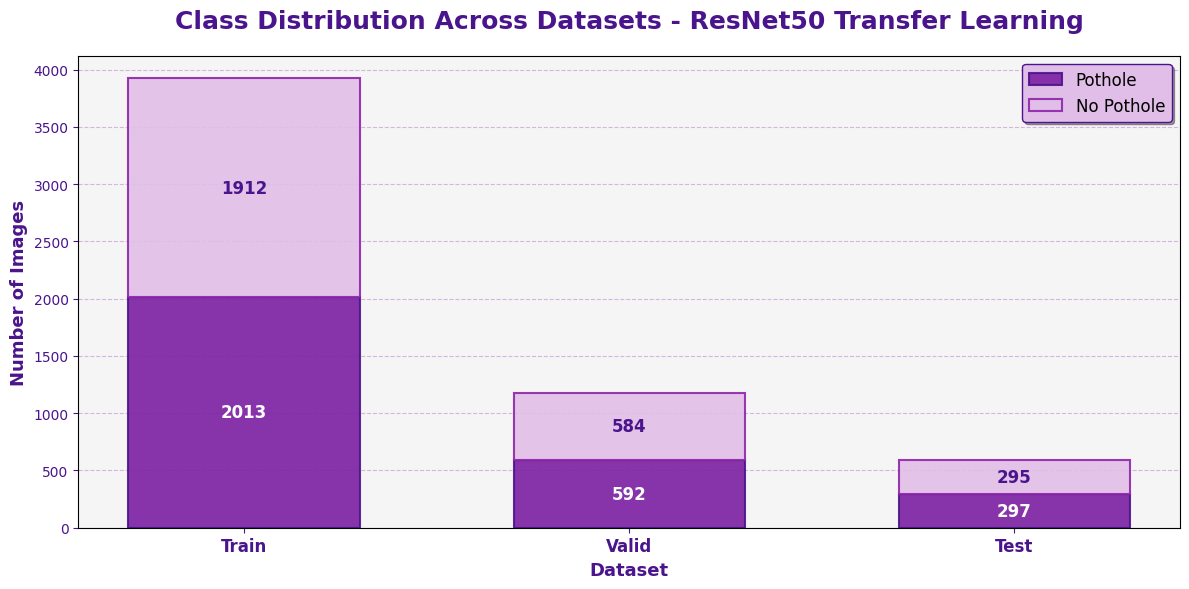

✅ Stacked bar chart saved!


In [10]:
# EDA Visualization: Stacked Bar Chart dengan tema Ungu-Hitam
fig, ax = plt.subplots(figsize=(12, 6), facecolor='white')
ax.set_facecolor('#F5F5F5')

x = np.arange(len(data_summary))
width = 0.6

# Warna: Ungu untuk Pothole, Ungu Muda untuk No Pothole
p1 = ax.bar(x, data_summary['Pothole'], width, 
            label='Pothole', 
            color=COLOR_SCHEME['pothole'], 
            alpha=0.9,
            edgecolor=COLOR_SCHEME['primary'],
            linewidth=1.5)

p2 = ax.bar(x, data_summary['No Pothole'], width, 
            bottom=data_summary['Pothole'],
            label='No Pothole', 
            color=COLOR_SCHEME['nopothole'], 
            alpha=0.9,
            edgecolor=COLOR_SCHEME['accent'],
            linewidth=1.5)

# Labels dan Title
ax.set_ylabel('Number of Images', fontsize=13, weight='bold', color=COLOR_SCHEME['primary'])
ax.set_xlabel('Dataset', fontsize=13, weight='bold', color=COLOR_SCHEME['primary'])
ax.set_title('Class Distribution Across Datasets - ResNet50 Transfer Learning', 
             fontsize=18, weight='bold', color=COLOR_SCHEME['primary'], pad=20)

ax.set_xticks(x)
ax.set_xticklabels(data_summary['Dataset'], fontsize=12, weight='bold')
ax.tick_params(colors=COLOR_SCHEME['primary'])

# Legend
ax.legend(fontsize=12, loc='upper right', frameon=True,
          facecolor=COLOR_SCHEME['light'], edgecolor=COLOR_SCHEME['primary'], shadow=True)

# Grid
ax.grid(axis='y', alpha=0.3, color=COLOR_SCHEME['accent'], linestyle='--', linewidth=0.8)
ax.set_axisbelow(True)

# Add value labels
for i, (p, np_val) in enumerate(zip(data_summary['Pothole'], data_summary['No Pothole'])):
    ax.text(i, p/2, str(p), ha='center', va='center', fontsize=12, weight='bold', color='white')
    ax.text(i, p + np_val/2, str(np_val), ha='center', va='center', fontsize=12, weight='bold', 
            color=COLOR_SCHEME['primary'])

plt.tight_layout()
plt.savefig(os.path.join(CONFIG['OUTPUT_PATH'], 'EDA', 'stacked_bar.png'), 
            dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

print("✅ Stacked bar chart saved!")

## 🔧 TAHAP 4: DATA LOADING (TANPA AUGMENTASI)

In [11]:
def load_dataset_from_flat_folder(folder_path, img_size=(224, 224)):
    """
    Load dataset with ResNet preprocessing
    NO DATA AUGMENTATION - as requested
    """
    from tensorflow.keras.applications.resnet50 import preprocess_input
    
    pothole_files = glob.glob(os.path.join(folder_path, 'POTHOLE_*'))
    nopothole_files = glob.glob(os.path.join(folder_path, 'NOPOTHOLE_*'))
    
    images = []
    labels = []
    
    print(f"  Loading {len(pothole_files)} pothole images...")
    for img_path in pothole_files:
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, img_size)
            img = preprocess_input(img)  # ResNet preprocessing
            images.append(img)
            labels.append(1)  # Pothole = 1
    
    print(f"  Loading {len(nopothole_files)} no pothole images...")
    for img_path in nopothole_files:
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, img_size)
            img = preprocess_input(img)  # ResNet preprocessing
            images.append(img)
            labels.append(0)  # No Pothole = 0
    
    return np.array(images), np.array(labels)

# Load all datasets
print("📥 Loading Training Data...")
X_train, y_train = load_dataset_from_flat_folder(
    os.path.join(CONFIG['DATASET_PATH'], 'train'),
    CONFIG['IMG_SIZE']
)

print("\n📥 Loading Validation Data...")
X_valid, y_valid = load_dataset_from_flat_folder(
    os.path.join(CONFIG['DATASET_PATH'], 'valid'),
    CONFIG['IMG_SIZE']
)

print("\n📥 Loading Test Data...")
X_test, y_test = load_dataset_from_flat_folder(
    os.path.join(CONFIG['DATASET_PATH'], 'test'),
    CONFIG['IMG_SIZE']
)

# Convert labels to categorical
y_train_cat = to_categorical(y_train, num_classes=2)
y_valid_cat = to_categorical(y_valid, num_classes=2)
y_test_cat = to_categorical(y_test, num_classes=2)

print("\n" + "="*70)
print("✅ DATA LOADED SUCCESSFULLY!")
print("="*70)
print(f"Train: {X_train.shape[0]} images")
print(f"  - Pothole: {np.sum(y_train == 1)}")
print(f"  - No Pothole: {np.sum(y_train == 0)}")
print(f"\nValid: {X_valid.shape[0]} images")
print(f"  - Pothole: {np.sum(y_valid == 1)}")
print(f"  - No Pothole: {np.sum(y_valid == 0)}")
print(f"\nTest: {X_test.shape[0]} images")
print(f"  - Pothole: {np.sum(y_test == 1)}")
print(f"  - No Pothole: {np.sum(y_test == 0)}")
print("="*70)
print("⚠️  ResNet50 Preprocessing Applied")
print("⚠️  NO DATA AUGMENTATION")
print("="*70)

📥 Loading Training Data...
  Loading 2013 pothole images...
  Loading 1912 no pothole images...

📥 Loading Validation Data...
  Loading 592 pothole images...
  Loading 584 no pothole images...

📥 Loading Test Data...
  Loading 297 pothole images...
  Loading 295 no pothole images...

✅ DATA LOADED SUCCESSFULLY!
Train: 3925 images
  - Pothole: 2013
  - No Pothole: 1912

Valid: 1176 images
  - Pothole: 592
  - No Pothole: 584

Test: 592 images
  - Pothole: 297
  - No Pothole: 295
⚠️  ResNet50 Preprocessing Applied
⚠️  NO DATA AUGMENTATION


## 🏗️ TAHAP 5: BUILD TRANSFER LEARNING MODEL (ResNet50 + FREEZE)

In [12]:
def create_resnet_transfer_model(input_shape=(224, 224, 3), num_classes=2):
    """
    Create ResNet50 Transfer Learning Model
    - Load pre-trained ResNet50 (ImageNet weights)
    - FREEZE base layers
    - Add custom top layers for our classification
    """
    
    # Load pre-trained ResNet50 (without top layers)
    base_model = ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )
    
    # FREEZE all base layers (as requested)
    base_model.trainable = False
    
    print(f"✅ ResNet50 base loaded (ImageNet weights)")
    print(f"🔒 Base layers FROZEN: {len(base_model.layers)} layers")
    
    # Build custom top layers
    model = models.Sequential([
        base_model,
        
        # Custom top layers (trainable)
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.BatchNormalization(),
        
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model, base_model

# Create model
model, base_model = create_resnet_transfer_model(
    input_shape=(*CONFIG['IMG_SIZE'], 3), 
    num_classes=CONFIG['NUM_CLASSES']
)

# Compile model
model.compile(
    optimizer=Adam(learning_rate=CONFIG['LEARNING_RATE']),
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

print("\n✅ Model created and compiled!")
print(f"Total params: {model.count_params():,}")
print(f"Trainable params: {sum([tf.size(w).numpy() for w in model.trainable_weights]):,}")
print(f"Non-trainable params: {sum([tf.size(w).numpy() for w in model.non_trainable_weights]):,}")

model.summary()

✅ ResNet50 base loaded (ImageNet weights)
🔒 Base layers FROZEN: 175 layers

✅ Model created and compiled!
Total params: 24,154,626
Trainable params: 562,306
Non-trainable params: 23,592,320


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,154,626 (92.14 MB)

 Trainable params: 562,306 (2.15 MB)

 Non-trainable params: 23,592,320 (90.00 MB)

## 🎯 TAHAP 6: TRAINING MODEL (dengan Early Stopping)

In [13]:
# Callbacks - EARLY STOPPING untuk prevent overfitting
model_callbacks = [
    ModelCheckpoint(
        os.path.join(CONFIG['OUTPUT_PATH'], 'Model', 'best_model.keras'),
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    EarlyStopping(
        monitor='val_accuracy',
        patience=3,  # Stop jika 3 epoch tidak ada improvement
        restore_best_weights=True,
        mode='max',
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        min_lr=1e-7,
        verbose=1
    )
]

print("✅ Callbacks configured!")
print("⚠️  Early Stopping: patience=3")
print("⚠️  Max Epochs: 15")

✅ Callbacks configured!
⚠️  Early Stopping: patience=3
⚠️  Max Epochs: 15


In [14]:
# Train the model
print("🚀 Starting Transfer Learning training...\n")

history = model.fit(
    X_train, y_train_cat,
    batch_size=CONFIG['BATCH_SIZE'],
    epochs=CONFIG['EPOCHS'],
    validation_data=(X_valid, y_valid_cat),
    callbacks=model_callbacks,
    verbose=1
)

print("\n✅ Training completed!")

🚀 Starting Transfer Learning training...

Epoch 1/5
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7685 - loss: 0.4901 - precision: 0.7685 - recall: 0.7685
Epoch 1: val_accuracy improved from -inf to 0.96854, saving model to C:\UAP_MachineLearning\ResNet50\Model\best_model.keras
123/123 ━━━━━━━━━━━━━━━━━━━━ 205s 2s/step - accuracy: 0.7693 - loss: 0.4886 - precision: 0.7693 - recall: 0.7693 - val_accuracy: 0.9685 - val_loss: 0.1055 - val_precision: 0.9685 - val_recall: 0.9685 - learning_rate: 1.0000e-04
Epoch 2/5
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9559 - loss: 0.1247 - precision: 0.9559 - recall: 0.9559
Epoch 2: val_accuracy improved from 0.96854 to 0.98044, saving model to C:\UAP_MachineLearning\ResNet50\Model\best_model.keras
123/123 ━━━━━━━━━━━━━━━━━━━━ 211s 2s/step - accuracy: 0.9559 - loss: 0.1247 - precision: 0.9559 - recall: 0.9559 - val_accuracy: 0.9804 - val_loss: 0.0554 - val_precision: 0.9804 - val_recall: 0.9804 - learning_rate: 1.0000e-04
Epoch 3/5

In [15]:
# Save training history
history_df = pd.DataFrame(history.history)
history_df.to_csv(os.path.join(CONFIG['OUTPUT_PATH'], 'Training', 'training_history.csv'), index=False)

with open(os.path.join(CONFIG['OUTPUT_PATH'], 'Training', 'training_history.pkl'), 'wb') as f:
    pickle.dump(history.history, f)

print("✅ Training history saved!")

✅ Training history saved!


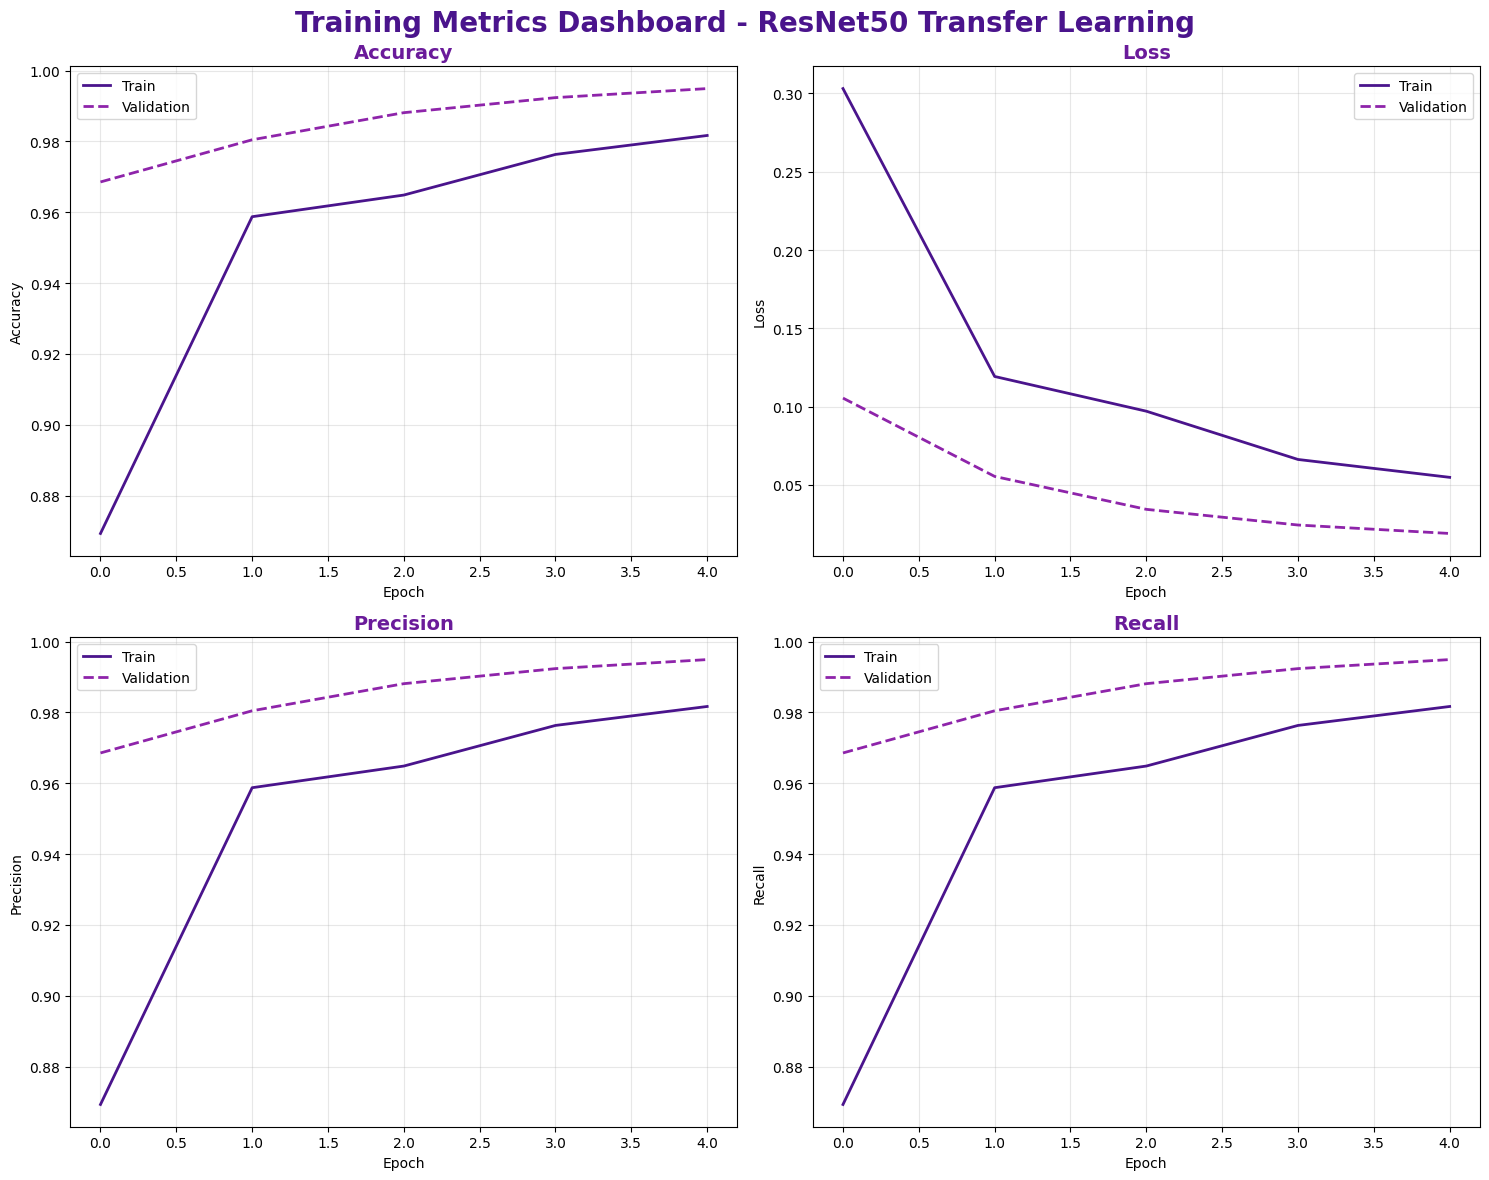

✅ Training visualization saved!


In [16]:
# Training Visualization dengan tema Ungu-Hitam
fig, axes = plt.subplots(2, 2, figsize=(15, 12), facecolor='white')
fig.suptitle('Training Metrics Dashboard - ResNet50 Transfer Learning', 
             fontsize=20, color=COLOR_SCHEME['primary'], weight='bold')

# Accuracy
axes[0, 0].plot(history.history['accuracy'], label='Train', 
                color=COLOR_SCHEME['primary'], linewidth=2)
axes[0, 0].plot(history.history['val_accuracy'], label='Validation', 
                color=COLOR_SCHEME['accent'], linewidth=2, linestyle='--')
axes[0, 0].set_title('Accuracy', fontsize=14, color=COLOR_SCHEME['secondary'], weight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Loss
axes[0, 1].plot(history.history['loss'], label='Train', 
                color=COLOR_SCHEME['primary'], linewidth=2)
axes[0, 1].plot(history.history['val_loss'], label='Validation', 
                color=COLOR_SCHEME['accent'], linewidth=2, linestyle='--')
axes[0, 1].set_title('Loss', fontsize=14, color=COLOR_SCHEME['secondary'], weight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Precision
axes[1, 0].plot(history.history['precision'], label='Train', 
                color=COLOR_SCHEME['primary'], linewidth=2)
axes[1, 0].plot(history.history['val_precision'], label='Validation', 
                color=COLOR_SCHEME['accent'], linewidth=2, linestyle='--')
axes[1, 0].set_title('Precision', fontsize=14, color=COLOR_SCHEME['secondary'], weight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Recall
axes[1, 1].plot(history.history['recall'], label='Train', 
                color=COLOR_SCHEME['primary'], linewidth=2)
axes[1, 1].plot(history.history['val_recall'], label='Validation', 
                color=COLOR_SCHEME['accent'], linewidth=2, linestyle='--')
axes[1, 1].set_title('Recall', fontsize=14, color=COLOR_SCHEME['secondary'], weight='bold')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Recall')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(CONFIG['OUTPUT_PATH'], 'Training', 'training_metrics.png'), 
            dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

print("✅ Training visualization saved!")

## 📈 TAHAP 7: EVALUATION & PREDICTION

In [17]:
# Evaluate on all datasets
print("\n" + "="*70)
print("EVALUATING ResNet50 MODEL")
print("="*70)

# Train
train_pred = np.argmax(model.predict(X_train), axis=1)
print("\nTRAIN SET:")
print(classification_report(y_train, train_pred, target_names=CONFIG['CLASSES']))

# Valid
valid_pred = np.argmax(model.predict(X_valid), axis=1)
print("\nVALIDATION SET:")
print(classification_report(y_valid, valid_pred, target_names=CONFIG['CLASSES']))

# Test
test_pred = np.argmax(model.predict(X_test), axis=1)
print("\nTEST SET:")
print(classification_report(y_test, test_pred, target_names=CONFIG['CLASSES']))

# Save predictions
predictions_df = pd.DataFrame({
    'True_Label': y_test,
    'Predicted_Label': test_pred,
    'True_Class': [CONFIG['CLASSES'][i] for i in y_test],
    'Predicted_Class': [CONFIG['CLASSES'][i] for i in test_pred],
    'Correct': y_test == test_pred
})
predictions_df.to_csv(os.path.join(CONFIG['OUTPUT_PATH'], 'Evaluation', 'test_predictions.csv'), index=False)

print("="*70)
print("✅ Evaluation completed!")


EVALUATING ResNet50 MODEL
123/123 ━━━━━━━━━━━━━━━━━━━━ 160s 1s/step

TRAIN SET:
              precision    recall  f1-score   support

   NOPOTHOLE       0.99      1.00      1.00      1912
     POTHOLE       1.00      0.99      1.00      2013

    accuracy                           1.00      3925
   macro avg       1.00      1.00      1.00      3925
weighted avg       1.00      1.00      1.00      3925

37/37 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step

VALIDATION SET:
              precision    recall  f1-score   support

   NOPOTHOLE       0.99      1.00      0.99       584
     POTHOLE       1.00      0.99      0.99       592

    accuracy                           0.99      1176
   macro avg       0.99      0.99      0.99      1176
weighted avg       0.99      0.99      0.99      1176

19/19 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step

TEST SET:
              precision    recall  f1-score   support

   NOPOTHOLE       0.99      0.99      0.99       295
     POTHOLE       0.99      0.99      0.99       

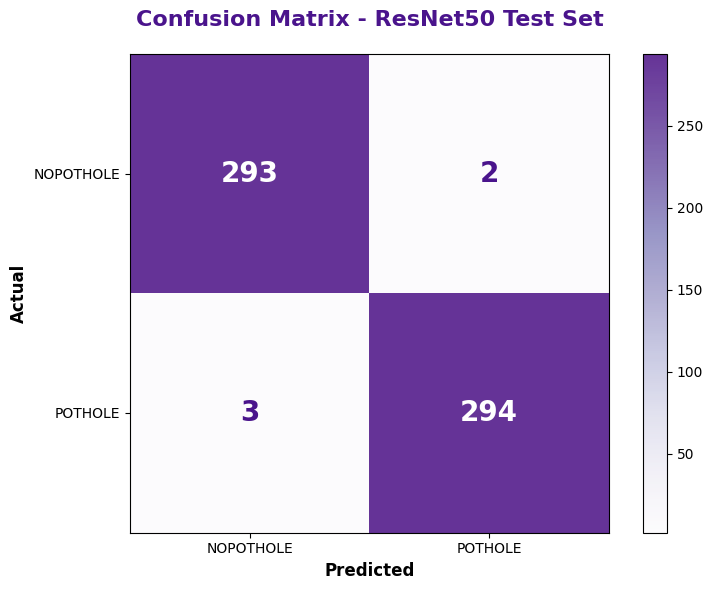

✅ Confusion matrix saved!


In [18]:
# Confusion Matrix dengan tema Ungu
cm = confusion_matrix(y_test, test_pred)

fig, ax = plt.subplots(figsize=(8, 6), facecolor='white')
im = ax.imshow(cm, cmap='Purples', alpha=0.8)
cbar = ax.figure.colorbar(im, ax=ax)

ax.set_xticks(np.arange(len(CONFIG['CLASSES'])))
ax.set_yticks(np.arange(len(CONFIG['CLASSES'])))
ax.set_xticklabels(CONFIG['CLASSES'])
ax.set_yticklabels(CONFIG['CLASSES'])

for i in range(len(CONFIG['CLASSES'])):
    for j in range(len(CONFIG['CLASSES'])):
        text = ax.text(j, i, cm[i, j], ha="center", va="center", 
                      color="white" if cm[i, j] > cm.max() / 2 else COLOR_SCHEME['primary'],
                      fontsize=20, weight='bold')

ax.set_title('Confusion Matrix - ResNet50 Test Set', fontsize=16, 
            color=COLOR_SCHEME['primary'], weight='bold', pad=20)
ax.set_ylabel('Actual', fontsize=12, weight='bold')
ax.set_xlabel('Predicted', fontsize=12, weight='bold')

plt.tight_layout()
plt.savefig(os.path.join(CONFIG['OUTPUT_PATH'], 'Evaluation', 'confusion_matrix.png'),
           dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

print("✅ Confusion matrix saved!")

## 🔍 TAHAP 8: ERROR ANALYSIS

In [19]:
# Error Analysis
print("\n" + "="*70)
print("🔍 ERROR ANALYSIS")
print("="*70)

misclassified_idx = np.where(test_pred != y_test)[0]

print(f"\nTotal Misclassified: {len(misclassified_idx)} / {len(y_test)}")
print(f"Error Rate: {(len(misclassified_idx)/len(y_test))*100:.2f}%")

# Error distribution
error_dist = pd.DataFrame({
    'True Class': [CONFIG['CLASSES'][y_test[i]] for i in misclassified_idx],
    'Predicted Class': [CONFIG['CLASSES'][test_pred[i]] for i in misclassified_idx]
})

error_summary = error_dist.groupby(['True Class', 'Predicted Class']).size().reset_index(name='Count')
print("\n📊 Error Distribution:")
print(error_summary)

error_summary.to_csv(os.path.join(CONFIG['OUTPUT_PATH'], 'Evaluation', 'error_analysis.csv'), index=False)

print("\n✅ Error analysis completed!")


🔍 ERROR ANALYSIS

Total Misclassified: 5 / 592
Error Rate: 0.84%

📊 Error Distribution:
  True Class Predicted Class  Count
0  NOPOTHOLE         POTHOLE      2
1    POTHOLE       NOPOTHOLE      3

✅ Error analysis completed!


## 🎨 TAHAP 9: XAI - SALIENCY MAP


🎨 EXPLAINABLE AI - SALIENCY MAP

🔍 Generating saliency maps...
  ✓ Sample 1/6 completed
  ✓ Sample 2/6 completed
  ✓ Sample 3/6 completed
  ✓ Sample 4/6 completed
  ✓ Sample 5/6 completed
  ✓ Sample 6/6 completed


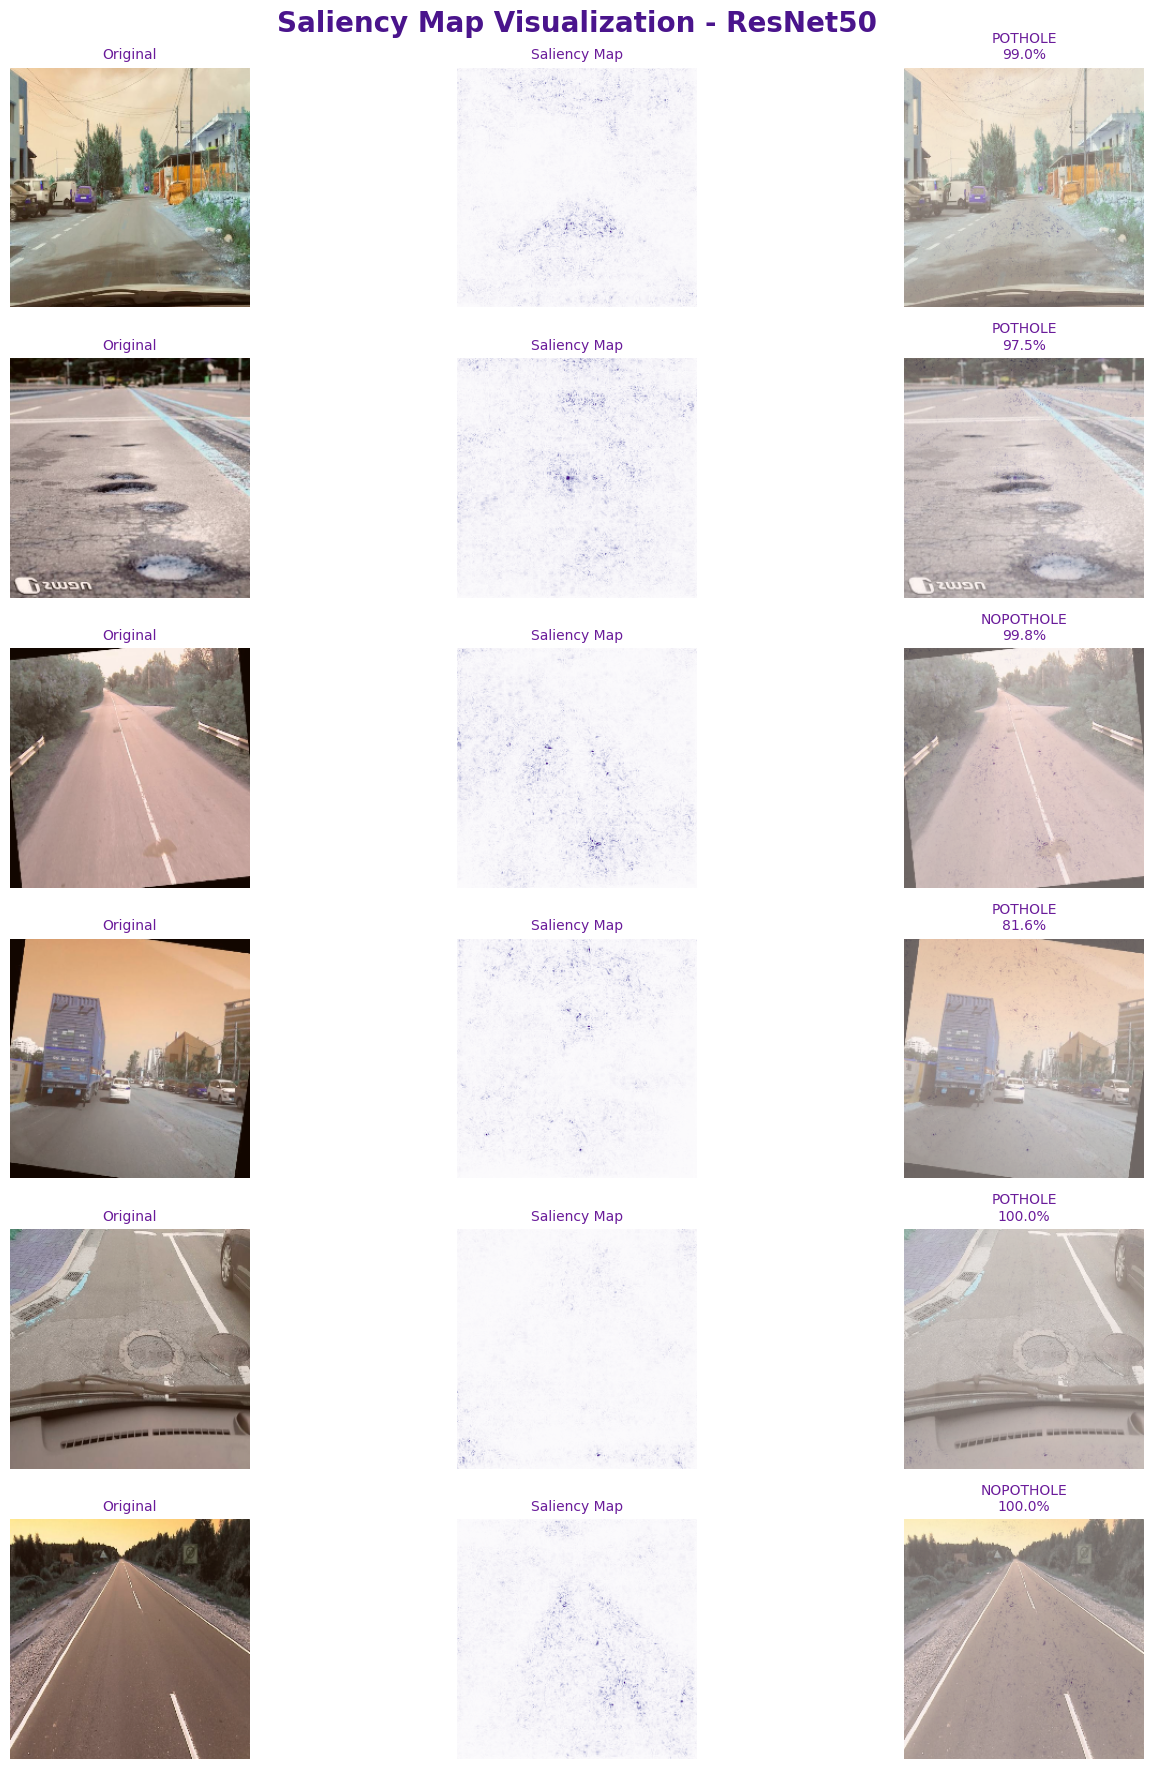


✅ Saliency map visualization completed!


In [20]:
# Saliency Map untuk Transfer Learning
print("\n" + "="*70)
print("🎨 EXPLAINABLE AI - SALIENCY MAP")
print("="*70)

def make_saliency_map(img_array, model, pred_index=None):
    """Generate saliency map"""
    img_tensor = tf.convert_to_tensor(img_array)
    
    with tf.GradientTape() as tape:
        tape.watch(img_tensor)
        predictions = model(img_tensor)
        
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        target_class = predictions[:, pred_index]
    
    gradients = tape.gradient(target_class, img_tensor)
    saliency = tf.reduce_max(tf.abs(gradients), axis=-1)
    saliency = saliency[0].numpy()
    saliency = (saliency - saliency.min()) / (saliency.max() - saliency.min() + 1e-10)
    
    return saliency

# Generate visualizations
num_samples = 6
sample_indices = np.random.choice(len(X_test), num_samples, replace=False)

fig, axes = plt.subplots(num_samples, 3, figsize=(15, num_samples*3), facecolor='white')
fig.suptitle('Saliency Map Visualization - ResNet50', 
             fontsize=20, color=COLOR_SCHEME['primary'], weight='bold')

print("\n🔍 Generating saliency maps...")
for idx, img_idx in enumerate(sample_indices):
    img_array = np.expand_dims(X_test[img_idx], axis=0)
    
    preds = model.predict(img_array, verbose=0)
    pred_class = np.argmax(preds[0])
    confidence = preds[0][pred_class]
    
    saliency = make_saliency_map(img_array, model, pred_class)
    
    # Denormalize image for display
    img_display = X_test[img_idx].copy()
    img_display = (img_display - img_display.min()) / (img_display.max() - img_display.min())
    img_display = (img_display * 255).astype('uint8')
    
    # Colorize saliency
    saliency_colored = plt.cm.Purples(saliency)[:, :, :3]
    saliency_colored = (saliency_colored * 255).astype('uint8')
    
    overlay = (img_display * 0.6 + saliency_colored * 0.4).astype('uint8')
    
    axes[idx, 0].imshow(img_display)
    axes[idx, 0].set_title('Original', color=COLOR_SCHEME['secondary'], fontsize=10)
    axes[idx, 0].axis('off')
    
    axes[idx, 1].imshow(saliency, cmap='Purples')
    axes[idx, 1].set_title('Saliency Map', color=COLOR_SCHEME['secondary'], fontsize=10)
    axes[idx, 1].axis('off')
    
    axes[idx, 2].imshow(overlay)
    axes[idx, 2].set_title(f'{CONFIG["CLASSES"][pred_class]}\n{confidence:.1%}', 
                          color=COLOR_SCHEME['secondary'], fontsize=10)
    axes[idx, 2].axis('off')
    
    print(f"  ✓ Sample {idx+1}/{num_samples} completed")

plt.tight_layout()
plt.savefig(os.path.join(CONFIG['OUTPUT_PATH'], 'XAI', 'saliency_maps.png'),
           dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

print("\n✅ Saliency map visualization completed!")

## 💾 TAHAP 10: SAVE FINAL MODEL

In [21]:
# Save final model
print("\n" + "="*70)
print("💾 SAVING FINAL MODEL")
print("="*70)

# Save complete model
model.save(os.path.join(CONFIG['OUTPUT_PATH'], 'Model', 'resnet50_final.keras'))
print("✅ Model saved: resnet50_final.keras")

# Save weights
model.save_weights(os.path.join(CONFIG['OUTPUT_PATH'], 'Model', 'resnet50.weights.h5'))
print("✅ Weights saved: resnet50.weights.h5")

# Save model architecture
with open(os.path.join(CONFIG['OUTPUT_PATH'], 'Model', 'model_architecture.txt'), 'w', encoding='utf-8') as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))
print("✅ Architecture saved: model_architecture.txt")

# Save model summary
summary = {
    'project_info': {
        'name': 'Pothole Detection System - Transfer Learning',
        'date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'model_type': 'ResNet50 Transfer Learning',
        'base_frozen': True,
        'classes': CONFIG['CLASSES']
    },
    'dataset': {
        'total_images': int(data_summary['Total'].sum()),
        'train': int(X_train.shape[0]),
        'valid': int(X_valid.shape[0]),
        'test': int(X_test.shape[0])
    },
    'performance': {
        'test_accuracy': float(accuracy_score(y_test, test_pred)),
        'test_precision': float(precision_score(y_test, test_pred)),
        'test_recall': float(recall_score(y_test, test_pred)),
        'test_f1': float(f1_score(y_test, test_pred))
    },
    'model_info': {
        'total_params': int(model.count_params()),
        'trainable_params': int(sum([tf.size(w).numpy() for w in model.trainable_weights])),
        'frozen_params': int(sum([tf.size(w).numpy() for w in model.non_trainable_weights]))
    }
}

with open(os.path.join(CONFIG['OUTPUT_PATH'], 'project_summary.json'), 'w', encoding='utf-8') as f:
    json.dump(summary, f, indent=4)

print("\n" + "="*70)
print("🎉 ALL TASKS COMPLETED SUCCESSFULLY!")
print("="*70)
print(json.dumps(summary, indent=2))
print("="*70)
print(f"\n📁 All outputs saved to: {CONFIG['OUTPUT_PATH']}")


💾 SAVING FINAL MODEL
✅ Model saved: resnet50_final.keras
✅ Weights saved: resnet50.weights.h5


✅ Architecture saved: model_architecture.txt

🎉 ALL TASKS COMPLETED SUCCESSFULLY!
{
  "project_info": {
    "name": "Pothole Detection System - Transfer Learning",
    "date": "2025-12-23 22:29:34",
    "model_type": "ResNet50 Transfer Learning",
    "base_frozen": true,
    "classes": [
      "NOPOTHOLE",
      "POTHOLE"
    ]
  },
  "dataset": {
    "total_images": 5693,
    "train": 3925,
    "valid": 1176,
    "test": 592
  },
  "performance": {
    "test_accuracy": 0.9915540540540541,
    "test_precision": 0.9932432432432432,
    "test_recall": 0.98989898989899,
    "test_f1": 0.9915682967959528
  },
  "model_info": {
    "total_params": 24154626,
    "trainable_params": 562306,
    "frozen_params": 23592320
  }
}

📁 All outputs saved to: C:\UAP_MachineLearning\ResNet50
